# Synchronization for MEA Recording
** Preprocessing **    
This notebook takes a MCD file that include the analog signal to recovery the synchronization time of all stimuli. It's very important step to analyze with precision the response of the recording cells. 

This codes create files with synchronization time for each frame, repeated frame time and a csv file with all relevant information about the stimuli. 

CSV file has a list of events, a event is a sequence of together images. Each event has a field of start and end time, number of frames, total time of the event, repeated frames and time inter event.

In [1]:
from configparser import ConfigParser, ExtendedInterpolation

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from spikelib.preprocessing import Sync
from spikelib.utils import check_directory

%matplotlib notebook 
config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../config.ini')

['../config.ini']

In [2]:
experiment_name = config['EXP']['name']
mcd_file = config['FILES']['raw']


## Get synchronization signal
To analyze synchronization signal we use a specific class in **mealib.preprocessing** called Sync. With this we can real MCD file and processing all information or use analyzed info previously.

input:   
* **mcd_file**: name of MCD file
* **mcd_channel**: number of analog channel in MCD file
* **real_fps**: the real number of frame per second on screen (look at log file)

output: 3 attributes of the class   
* **start_end_frame**: synchronization time for each frame
* **repeated_frame**: repeated frame time
* **total_duration**: total duration of MCD record

Note:
Analog signal only register the start of frame, so the end time in a sequence of images is extrapolate to have the correct time in the output file.

[example](https://tinyurl.com/ydxlvds9)

For more information look at [here](https://github.com/creyesp/SamplingInterface)

In [5]:
real_fps = 59.7233

sync_data = Sync(experiment_name, real_fps)
sync_data.read_mcd(mcd_file)
#Show electrodes in MCD file
sync_data.show_entities()

Entities in MCD file.
index:  	 label:  	 entity_type: 
0000: anlg0001 0126 0000       A1 type: 2
0001: anlg0001 0127 0001       A2 type: 2


Choose analog channel from index entites

In [4]:
mcd_channel = 0
sync_data.analyzer(mcd_channel)

# Event list
## Create event list
From start_end_frame attribute created above we can compute the difference between all frames and get only frames with a difference more than one frame to create a event.


<img src="https://raw.githubusercontent.com/creyesp/SamplingInterface/master/Doc/img/img%20examples/analog_signal_sequence_img.png" alt="Events" width="600px"/>

In [5]:
sync_data.create_events()
sync_data.event_list.head()

,n_frames,start_event,end_event,start_next_event,event_duration,event_duration_seg,inter_event_duration,inter_event_duration_seg,protocol_name,nd,intensity,extra_desciption,repetition_name
0,0,0,12544087,12544087,12544087,627.20435,0,0.00000,,,,,
1,108001,12544087,48664716,48728951,36120629,1806.03145,64235,3.21175,,,,,
2,809,48728951,48840328,48898938,111377,5.56885,58610,2.93050,,,,,
3,1950,48898938,49551110,49571177,652172,32.60860,20067,1.00335,,,,,
4,1950,49571177,50223348,50243416,652171,32.60855,20068,1.00340,,,,,


## Add repeated frame in the event lists
Some time the screen repeat one frame because the time to prepare the next frame wasn't reached and the screen show again the last frame. It should be critic in some case because the synchronization is lost in this case. If you know exactly the repeated frame you can correct the stimulus or discard this event.

<img src="https://raw.githubusercontent.com/creyesp/SamplingInterface/master/Doc/img/img%20examples/repeated_frame.png" alt="drawing" width="400px"/>

In [9]:
sync_data.add_repeated()
sync_data.event_list.head()

,n_frames,start_event,end_event,start_next_event,event_duration,event_duration_seg,inter_event_duration,inter_event_duration_seg,protocol_name,nd,intensity,extra_desciption,repetition_name,repeated_frames,#repeated_frames
0,0,0,12287807,12287807,12287807,614.39035,0,0.00000,,,,,,[12287807],1
1,1,12287807,12288141,12288476,334,0.01670,335,0.01675,,,,,,[12287807],1
2,1,12288476,12288810,12289146,334,0.01670,336,0.01680,,,,,,[12288476],1
3,3,12289146,12290148,12290150,1002,0.05010,2,0.00010,,,,,,[12289146 12289481 12289814],3
4,1,12290150,12290484,12290819,334,0.01670,335,0.01675,,,,,,[12290150],1


**Note:** The times in event_duration have small differences with the theatrical times, it's because the theatrical FPS of the projector is different to the real FPS.   

For example, projector show theoretically 60 FPS but the real FPS is 59.7523. Please check it in the log file. 
* 2100 images to 60 [fps] = 35 [s]
* 2100 images to 59.7523 [fps] = 35.145 [s]
The differences could be significant!

## Check repeated
There is a method to show analog signal in a specific window of time, we can use it to check repeated frame using the above information.

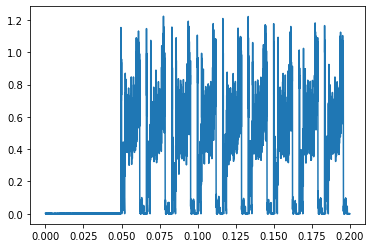

In [14]:
start_point = 73942046-1000
window = 4000
sync_data.plot_window(mcd_channel, start_point, window)

## Save sync to file

In [12]:
output_folder = '../data/sync/'+experiment_name+'/'
check_directory(output_folder)

sync_data.save_analyzed(output_folder)
sync_data.save_events(output_folder)

In [15]:
sync_data.close_file()

# Create separated sync files
For each event we can create a separated sync file using event information in csv. Before you have check the csv file and remove all false positive and you should write the name of events to do more easy understand them. 

Create a definitive version removing the last underscore name. '*_.csv' -> '*.csv'

In [9]:
source_folder = '../data/sync/'+experiment_name+'/'
output_folder = '../data/sync/'+experiment_name+'/event_list/'
check_directory(output_folder)
sample_rate = 20000

sync_data.load_analyzed(source_folder)
sync_data.load_events(source_folder + 'event_list_' + sync_data.exp_name + '.csv')
sync_data.create_separated_sync(output_folder)
